In [81]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
from ndbc_api import NdbcApi
from datetime import datetime, timedelta
import requests, tarfile, tqdm
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import glob
from cartopy.feature import GSHHSFeature
import cartopy.io.shapereader as shpreader
import matplotlib.dates as mdates
from datetime import datetime
import pytz
from datetime import timedelta, timezone
from matplotlib.ticker import FuncFormatter

# Choose your time zone (e.g., US/Eastern, UTC, Pacific/Honolulu, etc.)
plt.rcParams['font.family'] = 'Helvetica'  # Clean and modern
# plt.rcParams['font.family'] = 'DejaVu Sans'  # Has full font weights


In [22]:
# Set up dates and get station data
tz = pytz.timezone('UTC')
today = datetime.now(tz)
dates = {
    'today': today.strftime('%Y-%m-%d'),
    'yesterday': (today - timedelta(days=3)).strftime('%Y-%m-%d'),
    'tomorrow': (today + timedelta(days=3)).strftime('%Y-%m-%d')
}

time_range = pd.date_range(
    start=dates['yesterday'],
    end=dates['tomorrow'],
    freq='D'
)

yday = "".join(dates["yesterday"].split("-"))
tday = "".join(dates["today"].split("-"))

In [23]:
# Get station info
api = NdbcApi()
# station_id = '44090' #Nantucket
# station_id = '46221' #LA
station_id = "bzbm3"; station_name = "Woods Hole, MA"
station_meta = api.station(station_id=station_id)
location = station_meta["Location"].split()
latitude = float(location[0]) * (-1 if location[1] in ['S'] else 1)
longitude = float(location[2]) * (-1 if location[3] in ['W'] else 1)

In [24]:
bathy = xr.open_dataset("gebco_woho.nc").elevation
bathy = np.abs(bathy.where(bathy < 0))

In [25]:
# Get the data
df = api.get_data(
    station_ids=[station_id],
    mode='stdmet',
    start_time=dates['yesterday'],
    end_time=dates['tomorrow']
)[["WTMP"]].astype("float32")

df = df.reset_index()

# Convert 'timestamp' to datetime and set as index
df['time'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df.set_index('time')
df = df.sort_index()
df = df[~df.index.isna()]

# Drop original 'timestamp' column (no longer needed)
df = df.drop(columns=['timestamp'])

# Safety check: empty
if df.empty:
    raise ValueError(f"No data returned for station {station_id}")

print("df.head() before filtering")
print(df.head())

print("df.index[:10] before filtering")
print(df.index[:10])

df.index = pd.to_datetime(df.index, errors='coerce')
if df.index.tz is None:
    df.index = df.index.tz_localize('UTC')  # if originally in UTC
df.index = df.index.tz_convert('US/Eastern')
df.index = df.index.tz_localize(None)  # strip tz for plotting or xarray

print("df.head() after filtering")
print(df.head())


# Safety check: no usable numeric data
if df.empty:
    raise ValueError(f"No numeric data to convert for station {station_id}")

# Rename index for xarray and convert
df = df.rename_axis(index="time")

# 1. Make sure the index is datetime
df.index = pd.to_datetime(df.index, errors='coerce')

# 2. If index is naive (no tz), localize to UTC
if df.index.tz is None:
    df.index = df.index.tz_localize("UTC")

# 3. Convert to US/Eastern
df.index = df.index.tz_convert("US/Eastern")
df.index = df.index.tz_localize(None)

stdmet_df = xr.Dataset.from_dataframe(df)

stdmet_df_final = stdmet_df.isel(time=~stdmet_df["WTMP"].isnull().values).isel(time=-1)

df.head() before filtering
                          WTMP
time                          
2025-06-25 00:00:00  21.299999
2025-06-25 00:06:00  21.299999
2025-06-25 00:12:00  21.299999
2025-06-25 00:18:00  21.299999
2025-06-25 00:24:00  21.299999
df.index[:10] before filtering
DatetimeIndex(['2025-06-25 00:00:00', '2025-06-25 00:06:00',
               '2025-06-25 00:12:00', '2025-06-25 00:18:00',
               '2025-06-25 00:24:00', '2025-06-25 00:30:00',
               '2025-06-25 00:36:00', '2025-06-25 00:42:00',
               '2025-06-25 00:48:00', '2025-06-25 00:54:00'],
              dtype='datetime64[ns]', name='time', freq=None)
df.head() after filtering
                          WTMP
time                          
2025-06-24 20:00:00  21.299999
2025-06-24 20:06:00  21.299999
2025-06-24 20:12:00  21.299999
2025-06-24 20:18:00  21.299999
2025-06-24 20:24:00  21.299999


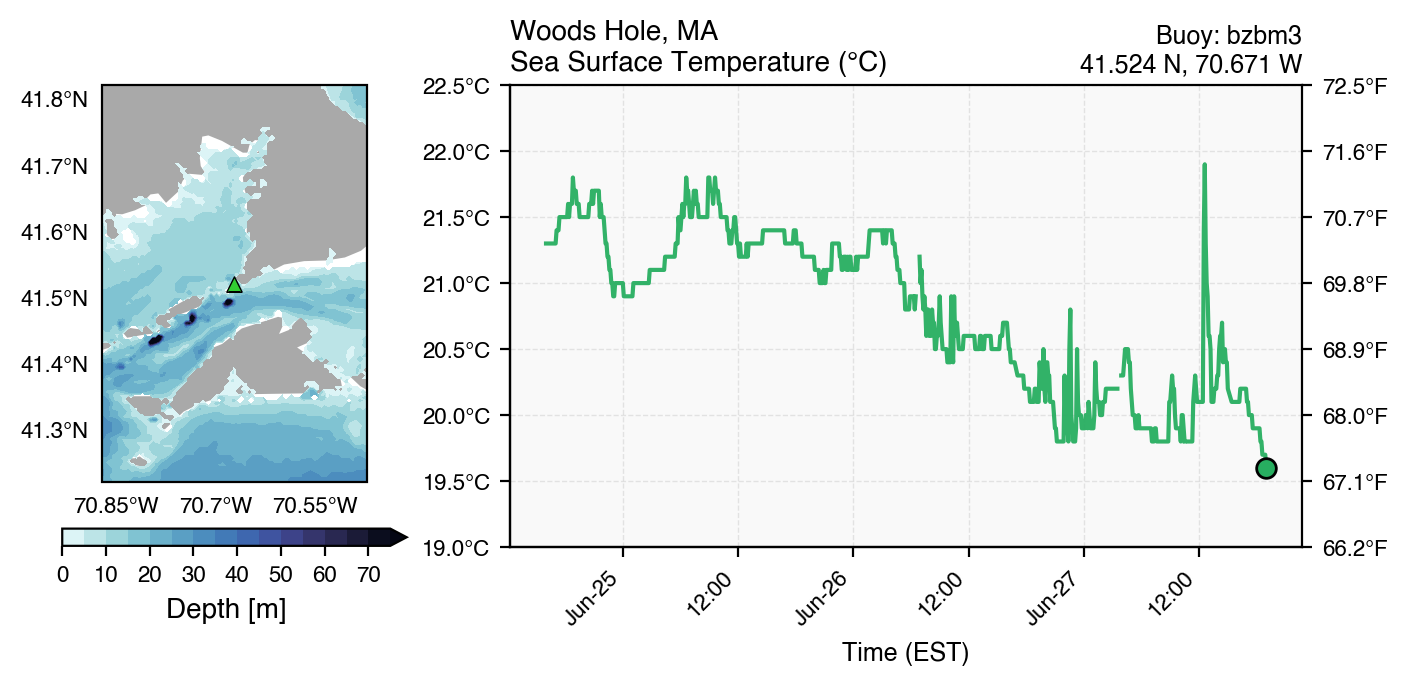

In [86]:
# Global settings (only light polish, no spine removal globally)
plt.rcParams.update({
    'axes.titlesize': 11,
    'axes.labelsize': 10,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'savefig.transparent': True,
})

# Create figure
fig = plt.figure(figsize=(8, 3), facecolor='white', dpi=200)
gs = gridspec.GridSpec(1, 3, figure=fig, wspace=0.3)

# -------- Bathymetry Map --------
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax1.add_feature(cfeature.LAND, facecolor='darkgrey')

contour = ax1.contourf(bathy.lon, bathy.lat, bathy,
                       levels=np.arange(0.0, 80, 5),
                       cmap=cmocean.cm.ice_r, extend="max",
                       transform=ccrs.PlateCarree())
cbar = fig.colorbar(contour, ax=ax1, orientation='horizontal',
                    pad=0.1, fraction=0.04, label='Depth [m]')
cbar.ax.tick_params(labelsize=8)

# Set map extent
dlon, dlat = 0.2, 0.3
extent = [longitude - dlon, longitude + dlon, latitude - dlat, latitude + dlat]
ax1.set_extent(extent)

# Gridlines
gl = ax1.gridlines(draw_labels=True, linewidth=0.25, color='gray',
                   alpha=0.0, linestyle='--')
gl.top_labels = gl.right_labels = False
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}

# Buoy marker
ax1.scatter(longitude, latitude, color='limegreen', s=30,
            marker='^', transform=ccrs.PlateCarree(),
            edgecolor='black', linewidth=0.5, zorder=10)

# -------- Time Series --------
ax2 = fig.add_subplot(gs[0, 1:])
ax2.set_facecolor("#f9f9f9")

# Remove only top and right spines
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Title (left-aligned)
ax2.text(0.0, 1.02, f"{station_name}\nSea Surface Temperature (°C)",
         transform=ax2.transAxes, ha='left', va='bottom', fontsize=10, weight='bold')

# Location (right-aligned)
ax2.text(1.0, 1.02, f"Buoy: {station_id}\n{' '.join(location[0:2])}, {' '.join(location[2:4])}",
         transform=ax2.transAxes, ha='right', va='bottom', fontsize=9)

# Plot time series (°C)
stdmet_df["WTMP"].plot(ax=ax2, color='#27ae60', linewidth=1.5, alpha=0.95, zorder=2)
ax2.scatter(stdmet_df_final.time, stdmet_df_final["WTMP"].values,
            color='#27ae60', edgecolor='black', s=50, zorder=5)

# Format time axis
ax2.xaxis.set_major_locator(mdates.AutoDateLocator())
ax2.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax2.xaxis.get_major_locator()))
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Axis labels and grid
ax2.set_xlabel('Time (EST)', fontsize=9)
ax2.set_ylabel('')

ax2.grid(True, linestyle='--', linewidth=0.5, alpha=0.3, zorder=0)
ax2.xaxis.get_offset_text().set_visible(False)

c_ticks = ax2.get_yticks()
ax2.set_yticks(c_ticks)
ax2.set_yticklabels([f"{c:.1f}°C" for c in c_ticks])

# -------- Fahrenheit Axis --------
ax2_f = ax2.twinx()
ax2_f.set_facecolor("#f9f9f9")

# Match y-limits and apply tick labels
ax2_f.set_ylim(c_ticks[0] * 9/5 + 32, c_ticks[-1] * 9/5 + 32)
ax2_f.set_yticks([(c * 9/5 + 32) for c in c_ticks])
ax2_f.set_yticklabels([f"{(c * 9/5 + 32):.1f}°F" for c in c_ticks])
ax2_f.tick_params(axis='y', labelsize=8)
ax2_f.grid(False)

ax2_f.tick_params(axis='y', labelsize=8)

# -------- Final save --------
# fig.tight_layout()
fig.texts.clear()  # remove any stray figure-wide text

fig.savefig("./images/temperature_plot.png", dpi=200, bbox_inches='tight')
